In [12]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import math
import numpy as np
import numpy.linalg as la
from PIL import Image

def perc_high(a):
    return np.percentile(a,q=90)

def perc_low(a):
    return np.percentile(a,q=10)

def load_fitness(filename):
    ids = []
    fits = []
    parents = []
    nbr_eval = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            ids.append(float(row[0]))
            fits.append(float(row[3]))
            nbr_eval.append(float(row[4]))
            parents.append(int(row[1]))
    return ids, fits, nbr_eval, parents

def find_index(_id,ids):
    for i in range(len(ids)):
        if(ids[i] == _id):
            return i

def compute_gen_rec(par_id,ids,parents):
    if(par_id == -1):
        return 0
    for i, id in zip(range(len(ids)),ids):
        if(par_id == id):
            return compute_gen_rec(parents[i],ids,parents) + 1

def compute_generation(ids,parents):
    generation = [0 for _ in range(len(ids))]
    for i in range(len(ids)):
        generation[i] = compute_gen_rec(parents[i],ids,parents)
    return generation

def load_descriptor(filename) :
    '''
    Load a list of descriptor from a file
    Trait descriptor: <width,depth,height,voxels,wheels,sensor,joint,caster>
    '''
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        descriptors = []
        for row in csv_data :
            desc = []
            for i in range(len(row)-1) :
                desc.append(float(row[i]))
            descriptors.append(desc)
        return descriptors
    
def load_controller_archive(filename):
    lines = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        coord = [0]*3
        state = 0
        nbr_param = 0
        i=0
        for row in csv_data:
            if(len(row) == 3):
                coord[0] = int(row[0])
                coord[1] = int(row[1])
                coord[2] = int(row[2])
                state = 1
                i=0
            elif(row[0]=='0 0 0 0'):
                continue
            elif(state == 1):
                nbr_param = int(row[0])
                state = 2
            elif(state == 2):
                nbr_param += int(row[0])
                state = 3
            elif(state == 3 and i < nbr_param):
                i+=1
            elif(state == 3 and i >= nbr_param):
                if(coord[1] == 0):
                    lines.append([coord[0],coord[2],float(row[0])])
    return pd.DataFrame(data=lines,columns=["number of wheels","number of sensors","fitness"])

def compute_lineage_rec(ids,par_id,parents):
    if(par_id == -1):
        return []
    for i, _id in zip(range(len(ids)),ids):
        if(par_id == _id):
            return [_id] + compute_lineage_rec(ids,parents[i],parents)
def compute_lineage(ids,parents):
    lineages = dict()
    for i, _id in zip(range(len(ids)),ids):
        lineages[_id] = compute_lineage_rec(ids,parents[i],parents)
    return lineages

def load_trajectory(filename):
    traj = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=';')
        t = 0
        for row in csv_data:
            position = row[0].split(',')
            pos = [float(elt) for elt in position]
            traj.append([t] + pos)
            t+=1
    return traj

def compute_runtime(filename,nbr_eval):
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        i = 0
        start_time = 0
        end_time = 0
        for row in csv_data:
            if(i==0):
                start_time = float(row[1])
            if(row[0] == "overhead"):
                continue
            if(i==nbr_eval):
                end_time = float(row[2])
            i+=1
    return end_time - start_time

def read_parameters(filename):
    '''
    Read a parameter and return a dictionnary
    '''
    parameters = dict()
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            parameters[row[0]] = row[2]
    return parameters

# Baseline

## Quality

/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 37.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'exploraton - arena')

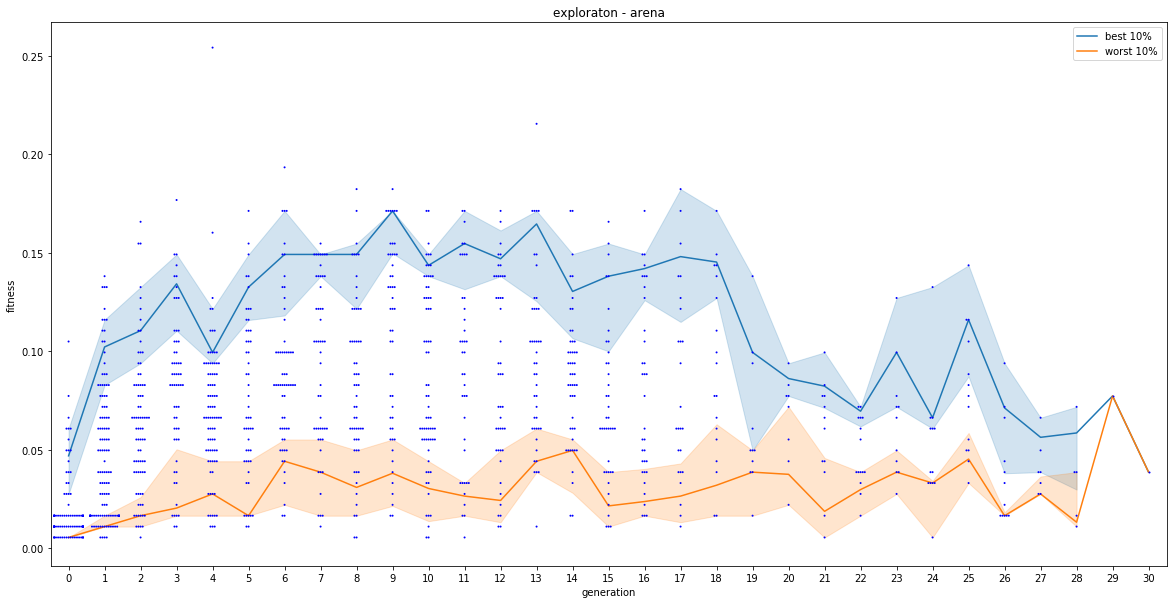

In [3]:
exp_folder = "/home/leni/are-logs/mnipes2_diversity2/baseline"
lines = []
for folder in os.listdir(exp_folder):
    ids, fitnesses, parents = load_fitness(exp_folder + "/" + folder + "/fitnesses.csv")
    generation = compute_generation(ids,parents)
    for _id, fit, gen in zip(ids,fitnesses,generation):
        lines.append([_id,fit,gen])

data = pd.DataFrame(data=lines,columns=["robot id","fitness","generation"]) 
data.drop_duplicates()
fig = plt.gcf()
fig.set_size_inches(20,10)
ax = sns.swarmplot(data=data,x="generation",y="fitness",size=2,color='b')
def perc(a):
    return np.percentile(a,q=90)
sns.lineplot(data=data,x="generation",y="fitness",estimator=perc_high,label="best 10%")
sns.lineplot(data=data,x="generation",y="fitness",estimator=perc_low,label="worst 10%")
ax.set_title("exploraton - arena")

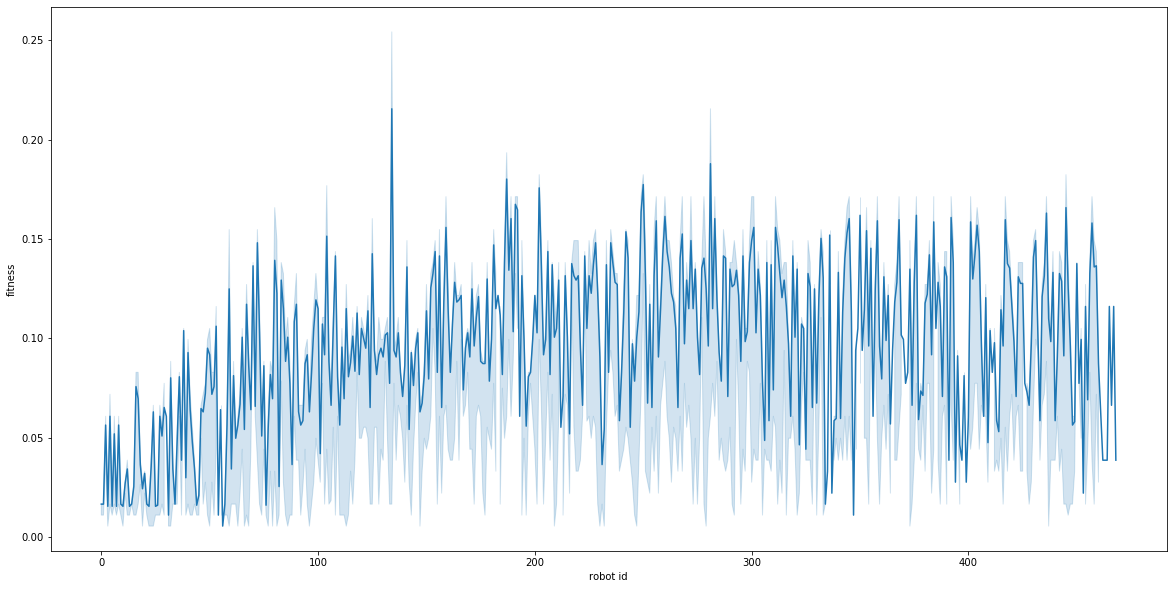

In [4]:
fig = plt.gcf()
fig.set_size_inches(20,10)
sns.lineplot(data=data,x="robot id",y="fitness",estimator=perc_high)

## Diversity

/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 46.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 51.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 48.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 45.1

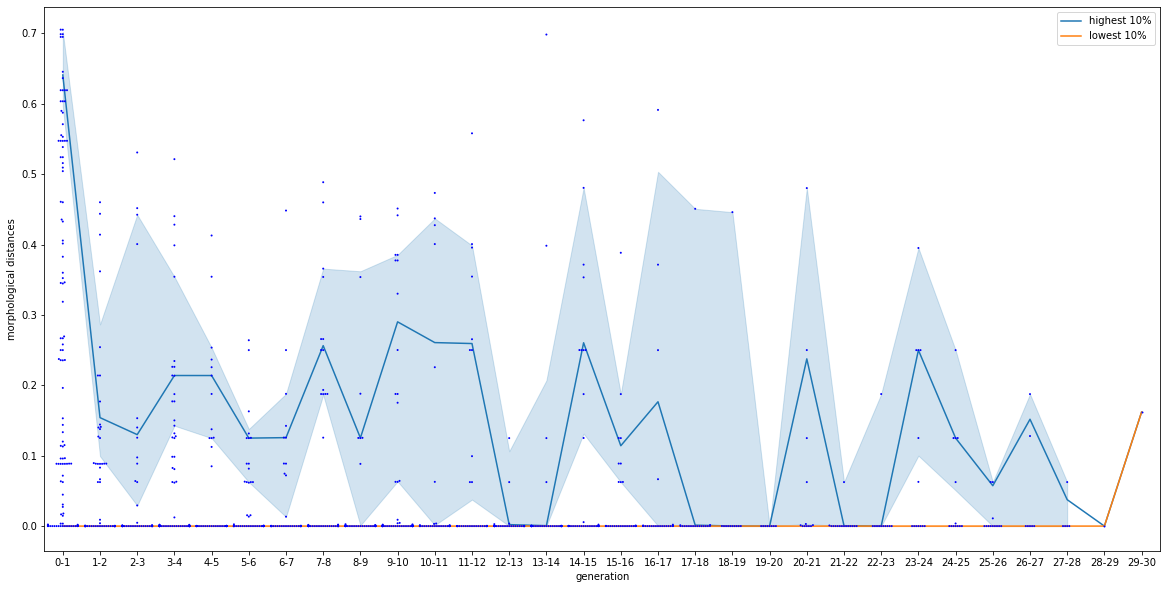

In [5]:
exp_folder = "/home/leni/are-logs/mnipes2_diversity2/baseline"
lines = []

for folder in os.listdir(exp_folder):
    ids, fitnesses, parents = load_fitness(exp_folder + "/" + folder + "/fitnesses.csv")
    lineages = compute_lineage(ids,parents)

    descriptors = load_descriptor(exp_folder + "/" + folder + "/morph_descriptors.csv")

    for k,v in lineages.items():
        prev_id = k
        j = find_index(k,ids)
        prev_desc = descriptors[j]
        prev_fit = fitnesses[j]
        for i, _id in zip(range(len(v)),v):
            j = find_index(_id,ids)
            dist = la.norm(np.array(descriptors[j][1:])-np.array(prev_desc[1:]))
            diff_fit = fitnesses[j] - prev_fit 
            lines.append([str(prev_id) + "-" + str(_id),str(len(v) - 1 - i)+"-"+str(len(v) - i),dist,diff_fit])
            prev_id = _id
            prev_desc = descriptors[j]
            prev_fit = fitnesses[j]

data = pd.DataFrame(data=lines,columns=["id","generation","morphological distances","fitness difference"])
data = data.drop_duplicates()
fig = plt.gcf()
fig.set_size_inches(20,10)
sns.swarmplot(data=data,x="generation",y="morphological distances",size=2,color='b')
sns.lineplot(data=data,x="generation",y="morphological distances",estimator=perc_high,label="highest 10%")
sns.lineplot(data=data,x="generation",y="morphological distances",estimator=perc_low,label="lowest 10%")

/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'exploration - arena')

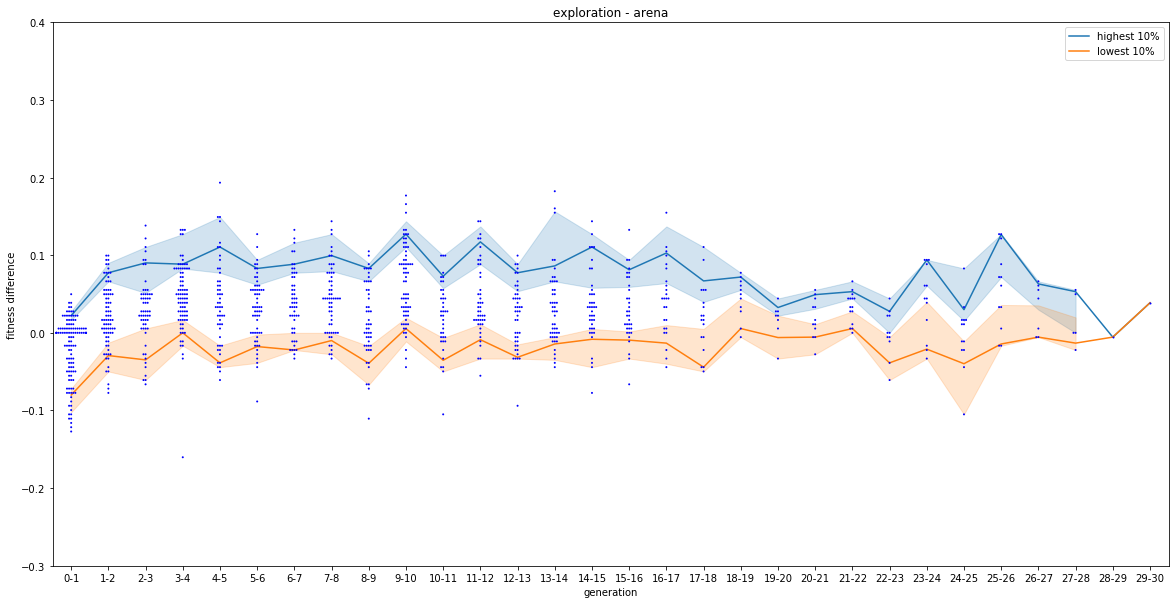

In [6]:
fig = plt.gcf()
fig.set_size_inches(20,10)
ax = sns.swarmplot(data=data,x="generation",y="fitness difference",size=2,color='b')
sns.lineplot(data=data,x="generation",y="fitness difference",estimator=perc_high,label="highest 10%")
sns.lineplot(data=data,x="generation",y="fitness difference",estimator=perc_low,label="lowest 10%")
ax.set_ylim([-0.3,0.4])
ax.set_title("exploration - arena")

# Learning

## Quality

/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 36.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'exploraton - arena')

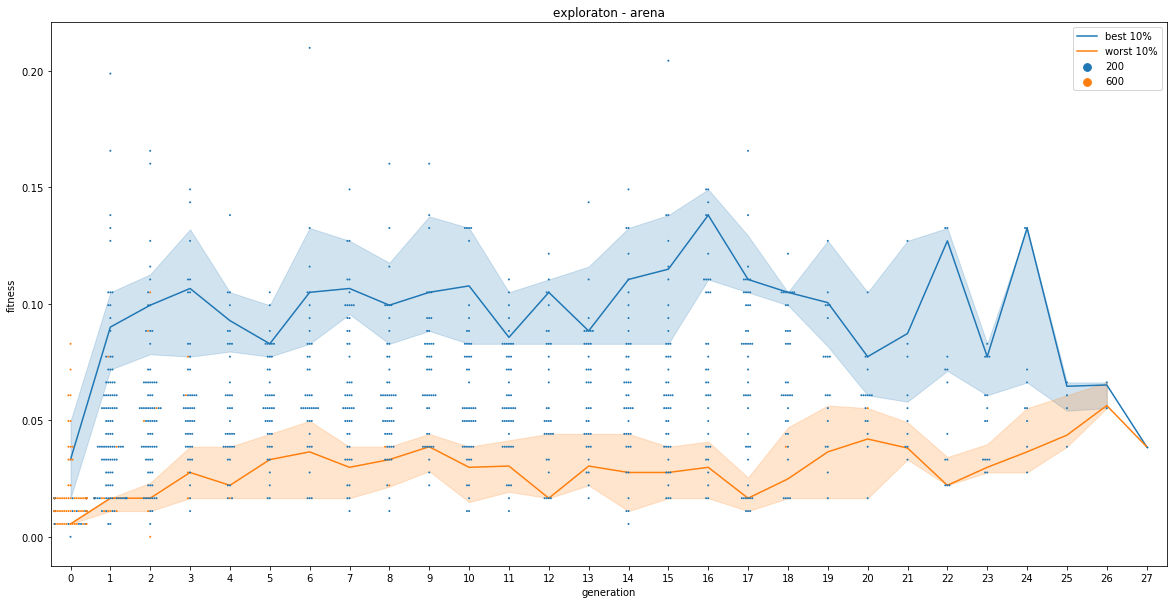

In [21]:
exp_folder = "/home/leni/are-logs/mnipes2_diversity2/learning"
lines = []
for folder in os.listdir(exp_folder):
    ids, fitnesses, nbr_eval, parents = load_fitness(exp_folder + "/" + folder + "/fitnesses.csv")
    generation = compute_generation(ids,parents)
    for _id, fit, e, gen in zip(ids,fitnesses,nbr_eval,generation):
        if e >= 600:
            e = 600
        else:
            e = 200
        lines.append([_id,fit,e,gen])

data = pd.DataFrame(data=lines,columns=["robot id","fitness","trials","generation"]) 
data.drop_duplicates()
fig = plt.gcf()
fig.set_size_inches(20,10)
ax = sns.swarmplot(data=data,x="generation",y="fitness",hue="trials",size=2,color='b',palette=sns.color_palette())
def perc(a):
    return np.percentile(a,q=90)
sns.lineplot(data=data,x="generation",y="fitness",estimator=perc_high,label="best 10%")
sns.lineplot(data=data,x="generation",y="fitness",estimator=perc_low,label="worst 10%")
ax.set_title("exploraton - arena")

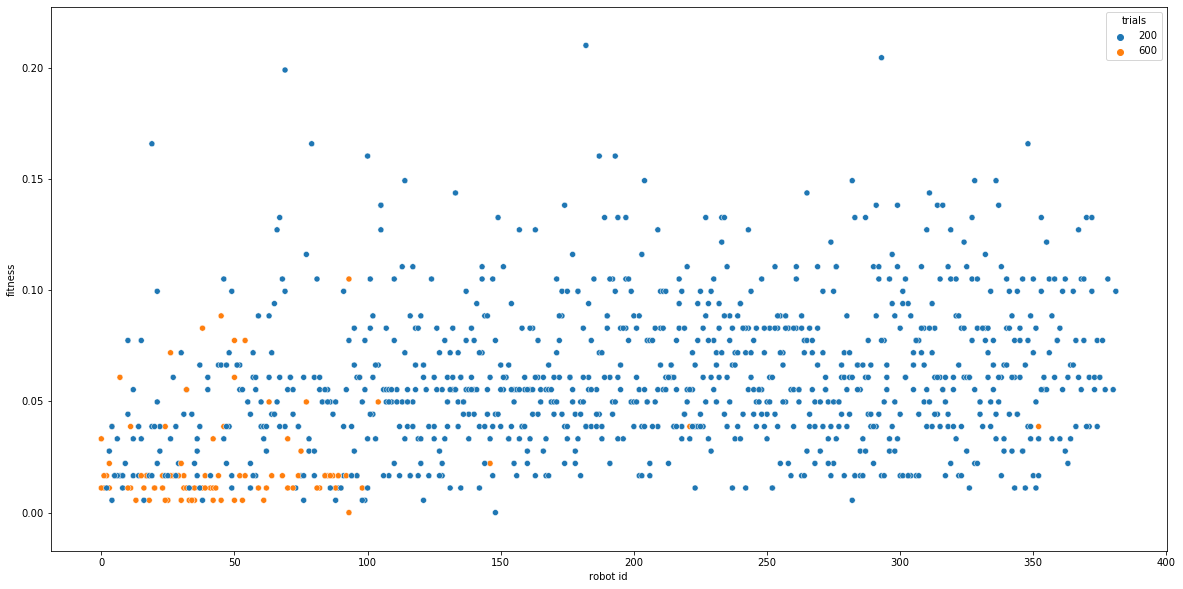

In [22]:
fig = plt.gcf()
fig.set_size_inches(20,10)
sns.scatterplot(data=data,x="robot id",y="fitness",hue="trials",palette=sns.color_palette(n_colors=2))

## Diversity

/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 46.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 51.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 48.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 45.1

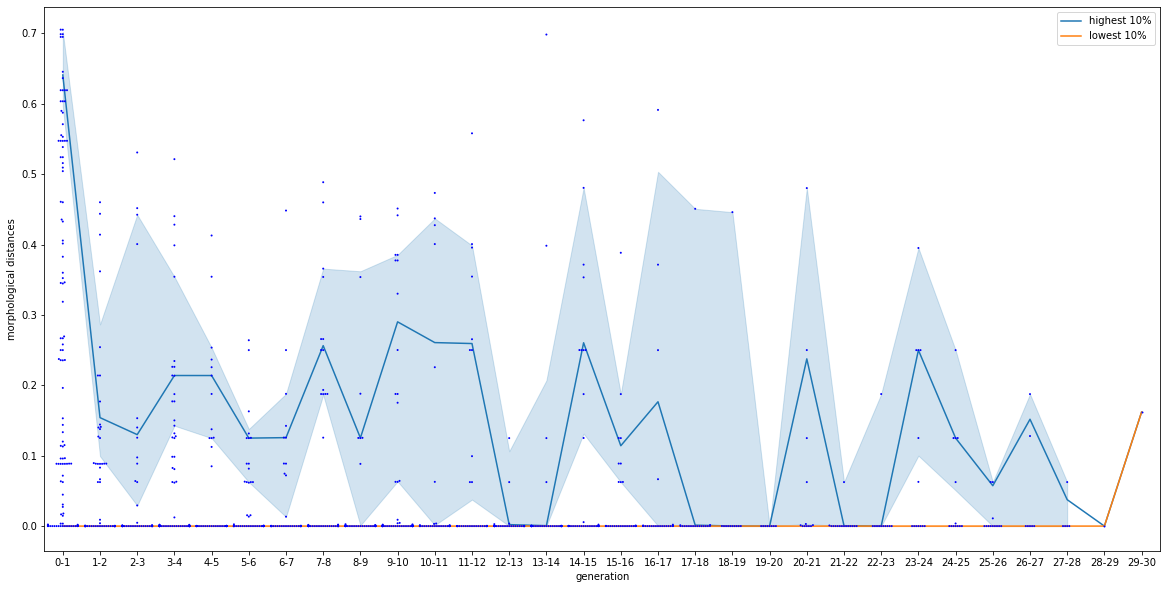

In [5]:
exp_folder = "/home/leni/are-logs/mnipes2_diversity2/learning"
lines = []

for folder in os.listdir(exp_folder):
    ids, fitnesses, parents = load_fitness(exp_folder + "/" + folder + "/fitnesses.csv")
    lineages = compute_lineage(ids,parents)

    descriptors = load_descriptor(exp_folder + "/" + folder + "/morph_descriptors.csv")

    for k,v in lineages.items():
        prev_id = k
        j = find_index(k,ids)
        prev_desc = descriptors[j]
        prev_fit = fitnesses[j]
        for i, _id in zip(range(len(v)),v):
            j = find_index(_id,ids)
            dist = la.norm(np.array(descriptors[j][1:])-np.array(prev_desc[1:]))
            diff_fit = fitnesses[j] - prev_fit 
            lines.append([str(prev_id) + "-" + str(_id),str(len(v) - 1 - i)+"-"+str(len(v) - i),dist,diff_fit])
            prev_id = _id
            prev_desc = descriptors[j]
            prev_fit = fitnesses[j]

data = pd.DataFrame(data=lines,columns=["id","generation","morphological distances","fitness difference"])
data = data.drop_duplicates()
fig = plt.gcf()
fig.set_size_inches(20,10)
sns.swarmplot(data=data,x="generation",y="morphological distances",size=2,color='b')
sns.lineplot(data=data,x="generation",y="morphological distances",estimator=perc_high,label="highest 10%")
sns.lineplot(data=data,x="generation",y="morphological distances",estimator=perc_low,label="lowest 10%")

/home/leni/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'exploration - arena')

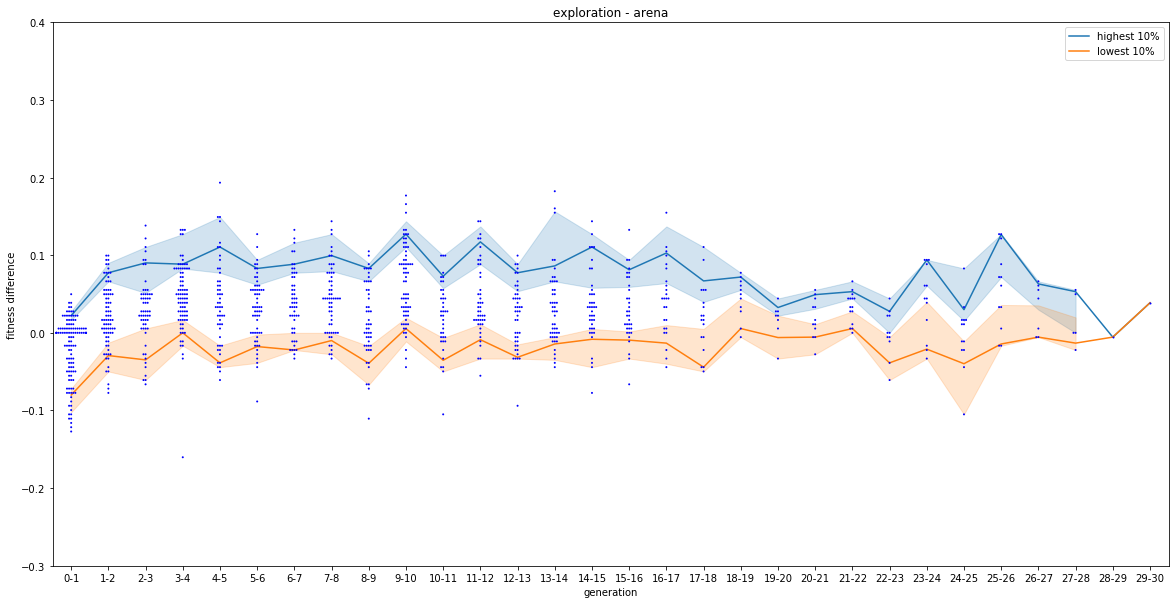

In [6]:
fig = plt.gcf()
fig.set_size_inches(20,10)
ax = sns.swarmplot(data=data,x="generation",y="fitness difference",size=2,color='b')
sns.lineplot(data=data,x="generation",y="fitness difference",estimator=perc_high,label="highest 10%")
sns.lineplot(data=data,x="generation",y="fitness difference",estimator=perc_low,label="lowest 10%")
ax.set_ylim([-0.3,0.4])
ax.set_title("exploration - arena")